In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 


## EDA

In [2]:
recipes = pd.read_csv('../data/recipes_clean.csv')
recipes.head()

,link,blog,type,Flour (%),Sugar (%),Eggs (%),Vanilla (%),Baking Powder (%),Butter (%)
0,https://www.thebakerchick.com/strawberry-lemon...,The Baker Chick,cupcake,42.352941,28.235294,14.117647,0.294118,0.882353,14.117647
1,https://www.thebakerchick.com/apple-cider-cupc...,The Baker Chick,cupcake,46.451613,20.645161,15.483871,0.645161,1.290323,15.483871
2,https://www.thebakerchick.com/vegan-chocolate-...,The Baker Chick,cupcake,49.202733,32.801822,0.000000,0.683371,2.733485,14.578588
3,https://www.thebakerchick.com/perfect-vanilla-...,The Baker Chick,cupcake,47.151277,33.005894,9.430255,0.000000,0.982318,9.430255
4,https://www.thebakerchick.com/caramel-mocha-ic...,The Baker Chick,cupcake,38.400000,38.400000,12.800000,0.533333,3.466667,6.400000


Text(0.5, 1.0, '')

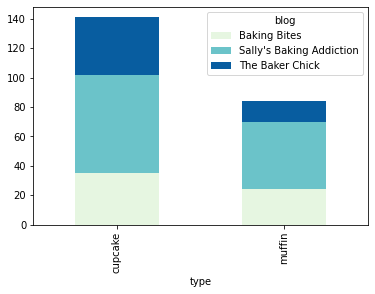

In [3]:
counts = recipes.groupby(['blog','type']).size().reset_index(name='Count')
pivot_df = counts.pivot_table(index='type',columns='blog',values='Count')
pivot_df.plot(kind='bar',stacked=True,colormap=ListedColormap(sns.color_palette("GnBu", 10)))
plt.title('')

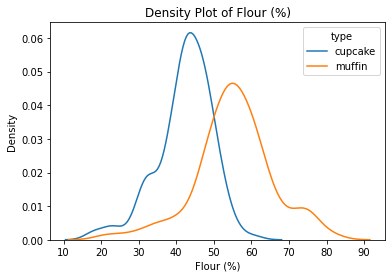

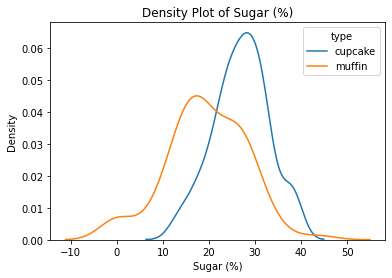

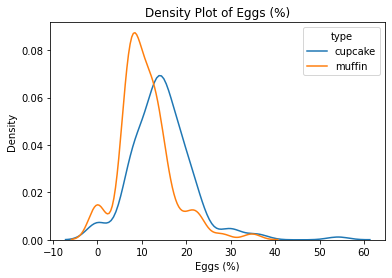

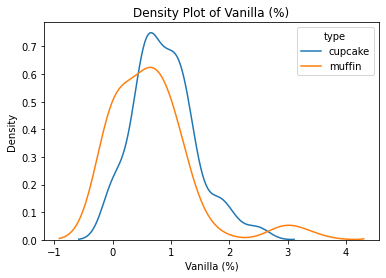

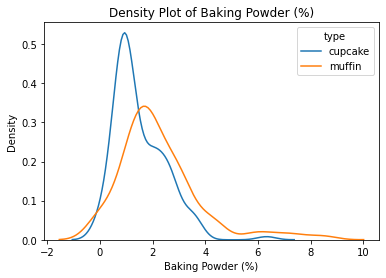

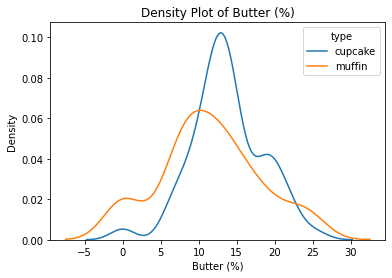

In [4]:
types = recipes['type'].unique()
ingredients = recipes.columns[3:]
for i in ingredients:
    for t in types:
        subset = recipes.loc[recipes['type']==t,i]
        sns.distplot(subset, hist = False, label=t)
    plt.legend(prop={'size': 10}, title = 'type')
    plt.title('Density Plot of ' + i)
    plt.ylabel('Density')
    plt.show()

In [21]:
# baking powder is higher since skinny muffin recipes
recipes[recipes['Baking Powder (%)']>4]

,link,blog,type,Flour (%),Sugar (%),Eggs (%),Vanilla (%),Baking Powder (%),Butter (%)
46,https://www.thebakerchick.com/dark-chocolate-b...,The Baker Chick,muffin,58.855586,9.809264,9.809264,0.000000,4.087193,17.438692
52,https://www.thebakerchick.com/blueberry-bran-m...,The Baker Chick,muffin,40.563380,27.042254,10.140845,0.000000,4.225352,18.028169
110,https://sallysbakingaddiction.com/skinny-choco...,Sally's Baking Addiction,cupcake,30.379747,30.379747,30.379747,2.531646,6.329114,0.000000
122,https://sallysbakingaddiction.com/simple-morni...,Sally's Baking Addiction,muffin,51.520572,12.880143,19.320215,0.536673,4.293381,11.449016
129,https://sallysbakingaddiction.com/blueberry-al...,Sally's Baking Addiction,muffin,34.782609,0.000000,34.782609,2.898551,4.347826,23.188406
133,https://sallysbakingaddiction.com/whole-wheat-...,Sally's Baking Addiction,muffin,58.536585,0.000000,14.634146,1.219512,6.097561,19.512195
140,https://sallysbakingaddiction.com/130-calorie-...,Sally's Baking Addiction,muffin,27.906977,27.906977,27.906977,1.162791,5.813953,9.302326
145,https://sallysbakingaddiction.com/skinny-choco...,Sally's Baking Addiction,muffin,40.677966,27.118644,20.338983,3.389831,8.474576,0.000000
148,https://sallysbakingaddiction.com/skinny-peanu...,Sally's Baking Addiction,muffin,73.043478,10.434783,10.434783,1.739130,4.347826,0.000000
152,https://sallysbakingaddiction.com/skinny-doubl...,Sally's Baking Addiction,muffin,35.820896,35.820896,17.910448,2.985075,7.462687,0.000000


### Simulation

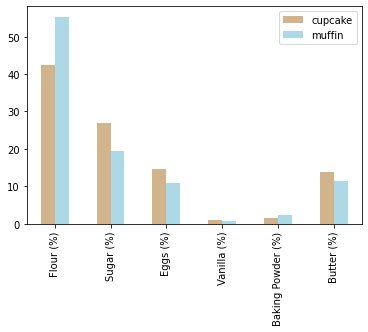

In [5]:
def mean_ingredients(df, col, t):
    return df.loc[df[col]==t,ingredients].apply(np.mean).rename(t)

cupcake_mean = mean_ingredients(recipes, 'type', 'cupcake')
muffin_mean = mean_ingredients(recipes, 'type', 'muffin')
pd.concat([cupcake_mean,muffin_mean],axis=1).plot(kind='bar', color=['tan','lightblue'])
plt.show()

In [6]:
def tvd(d1, d2):
    return sum(np.abs(d1 - d2)) / 2

observed_tvd = tvd(cupcake_mean, muffin_mean)
observed_tvd

13.82819471485969

In [7]:
def simulate_tvd():
    shuffled_df = recipes.assign(shuffled_typed = recipes['type'].sample(frac=1).values)
    cupcake_mean = mean_ingredients(shuffled_df, 'shuffled_typed', 'cupcake')
    muffin_mean = mean_ingredients(shuffled_df, 'shuffled_typed', 'muffin')
    return tvd(cupcake_mean, muffin_mean)

Text(0.5, 1.0, 'Simulated TVD Distribution')

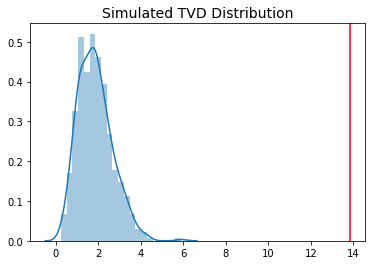

In [8]:
tvds = []
for i in np.arange(500):
    tvds.append(simulate_tvd())

sns.distplot(tvds)
plt.axvline(observed_tvd, color = 'red')
plt.title("Simulated TVD Distribution", fontsize=14)
plt.show()

## Models

In [12]:
X = recipes[ingredients]
y = recipes['type'].apply(lambda x:1 if x=='muffin' else -1)

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
220   -1
221   -1
222   -1
223   -1
224   -1
Name: type, Length: 225, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=234)

### Decision Trees

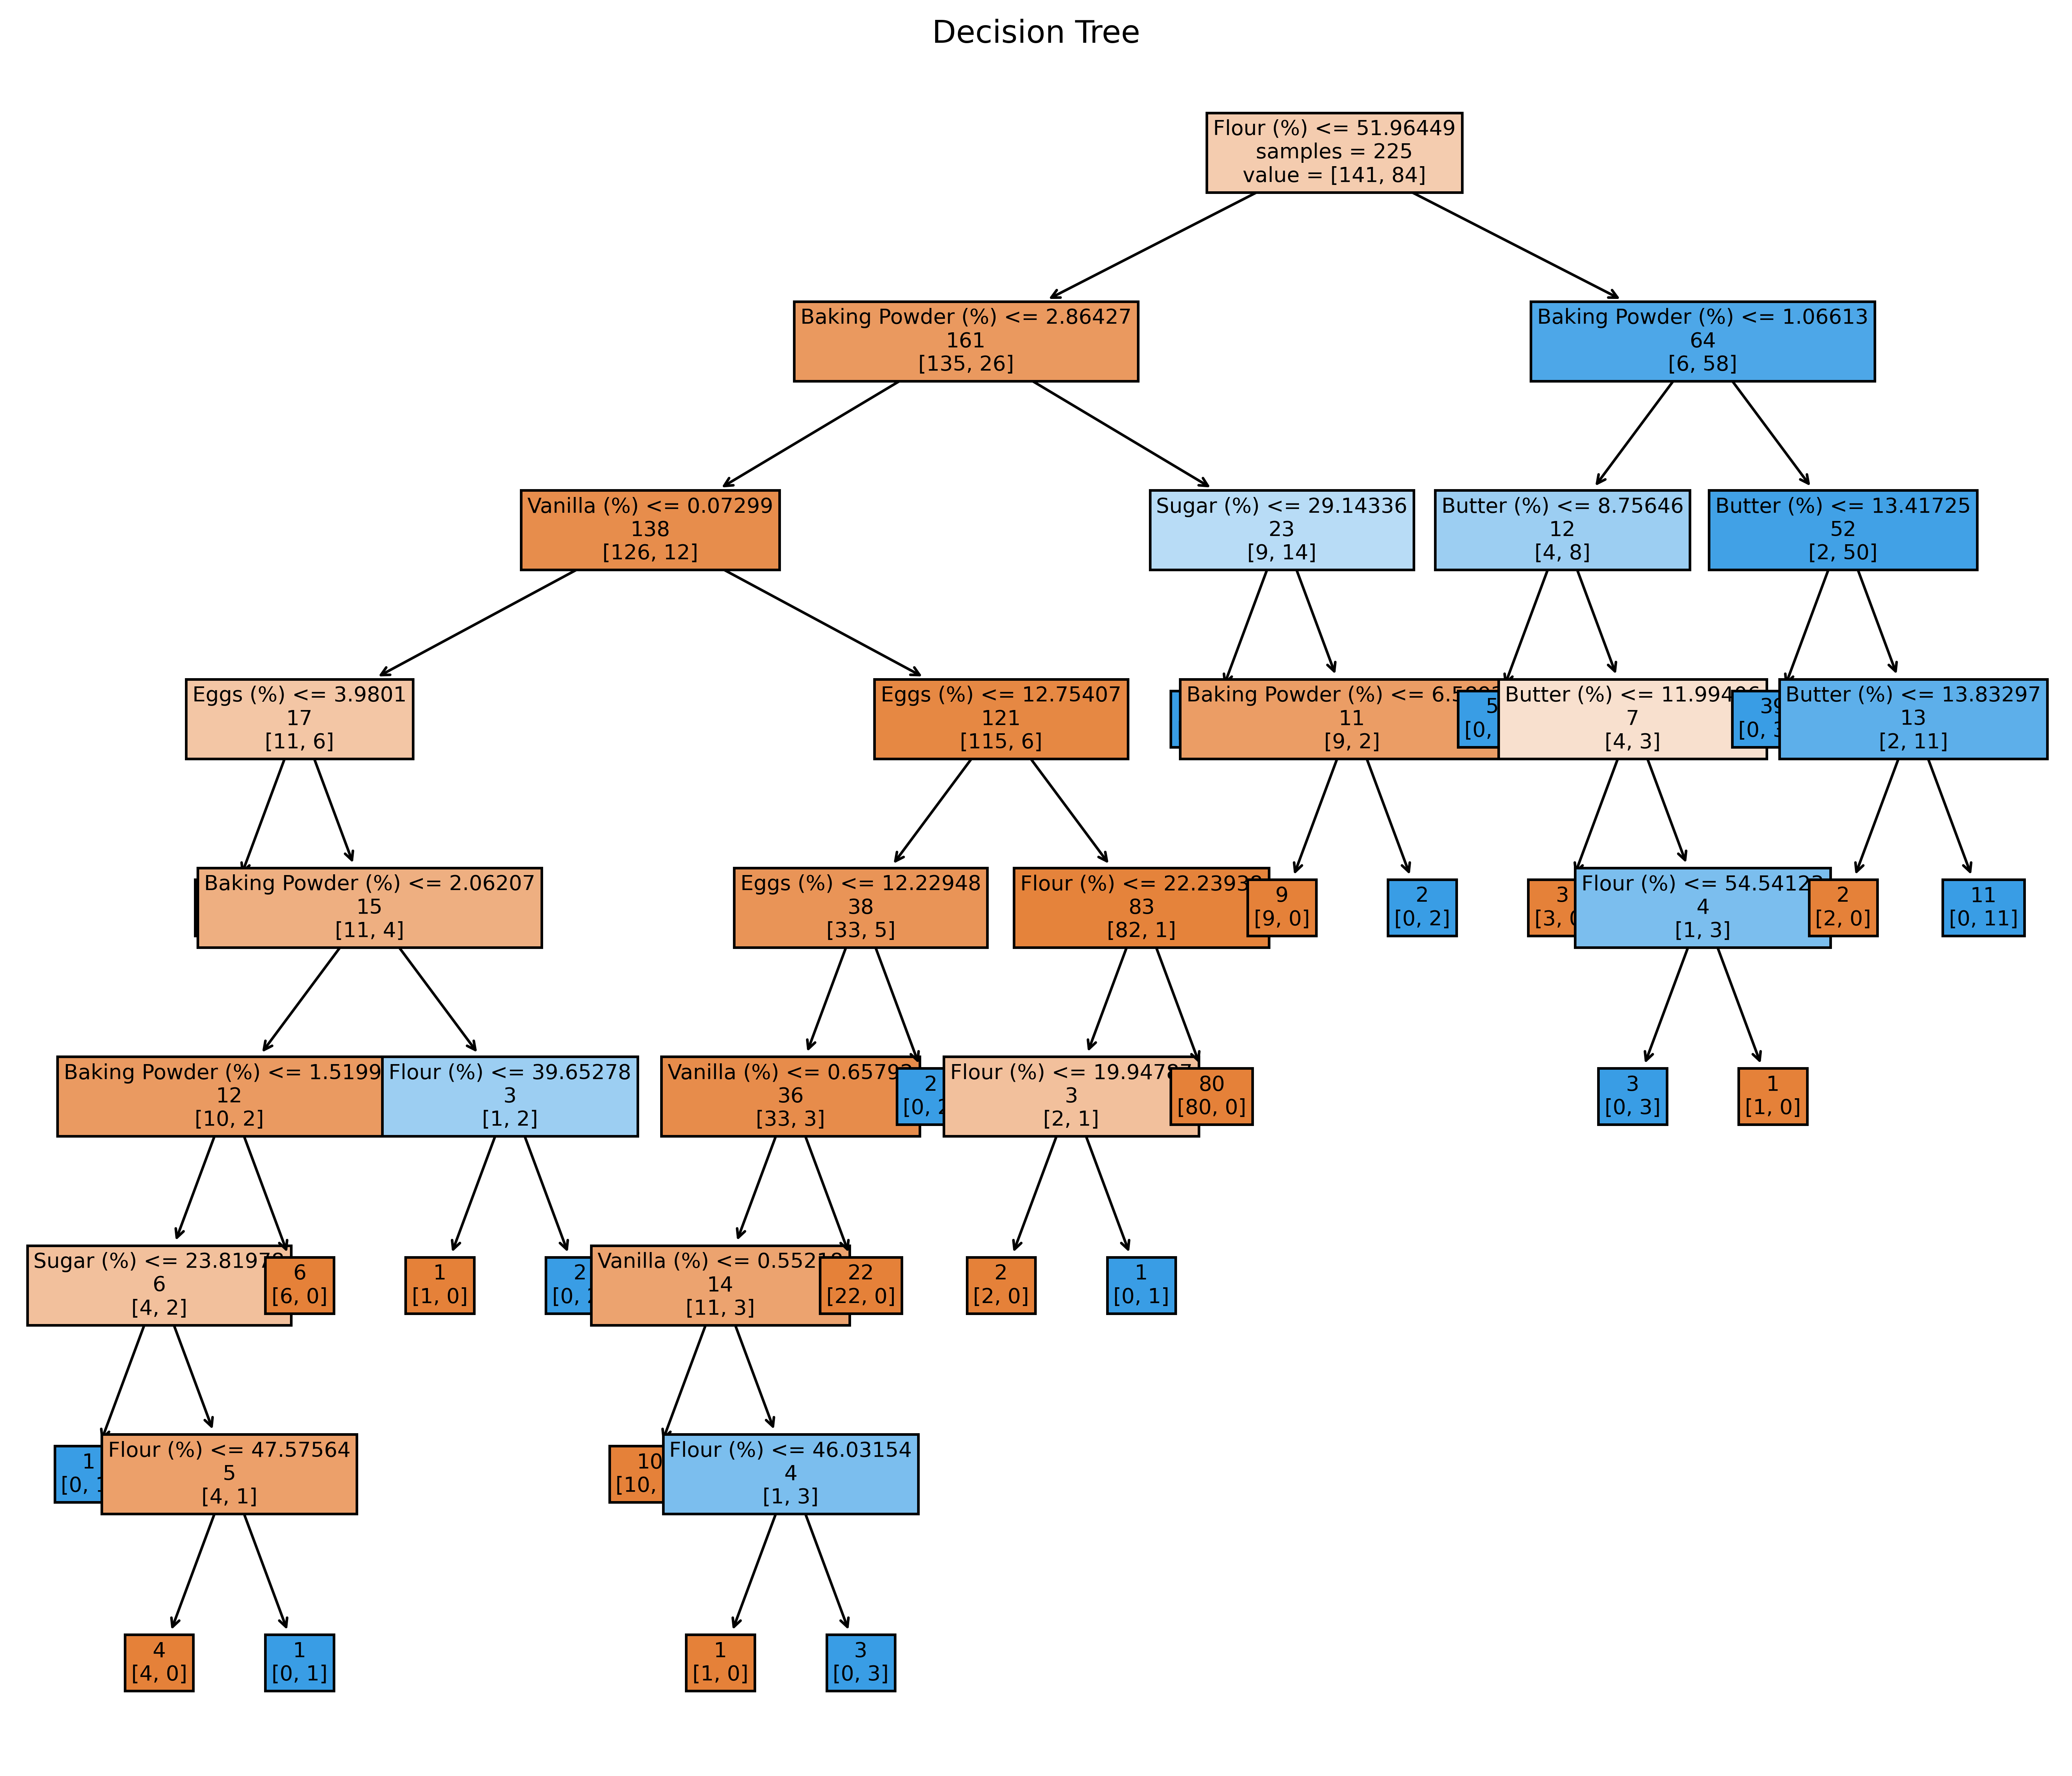

In [52]:
model = DecisionTreeClassifier()
model.fit(X, y)

# plot decision tree
fig = plt.figure(figsize = (14,12), dpi=500)
tree.plot_tree(model,feature_names = ingredients,filled=True,fontsize=8,label='root',impurity=False, precision=5)
plt.title("Decision Tree")
plt.show()

Feature: Flour (%), Score: 0.5576724209321949
Feature: Sugar (%), Score: 0.0831160821910128
Feature: Eggs (%), Score: 0.05534853988330541
Feature: Vanilla (%), Score: 0.06405185142688043
Feature: Baking Powder (%), Score: 0.16686764831463852
Feature: Butter (%), Score: 0.0729434572519679


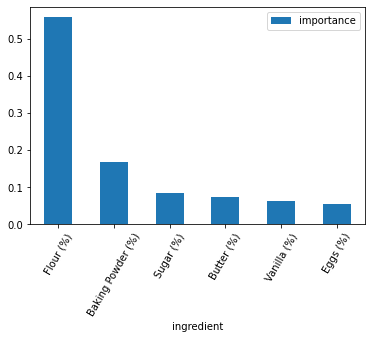

In [53]:
# summarize feature importance
importance = list(zip(ingredients,model.feature_importances_))
for i in importance:
    print('Feature: {0}, Score: {1}'.format(i[0],i[1]))
    
importance_df = pd.Series(importance).apply(pd.Series).rename(
    {0:'ingredient',1:'importance'},axis=1
    ).set_index('ingredient').sort_values(by='importance',ascending=False)
importance_df.plot(kind='bar')
plt.xticks(rotation=60)
plt.show()